In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model, Sequential # Import Sequential here
from keras.saving import save_model


from keras.metrics import MeanSquaredError
from tensorflow.keras.layers import Dense, Dropout
import joblib

# Load dataset (format: R,G,B,pH)
data = pd.read_csv("/content/augmented_soilpH_rgb.csv")
X = data[['R', 'G', 'B']].values
y = data['pH'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Normalize RGB values
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(pca.components_)


# Save preprocessing objects
joblib.dump(scaler, 'rgb_scaler.joblib')
joblib.dump(pca, 'pca_model.joblib')

# Neural Network Model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_pca.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train model
history = model.fit(X_train_pca, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)

# Save model
model.save('soil_ph_model.h5')
save_model(model, 'keras3_compatible_model.keras')

# Evaluate
test_loss, test_mae = model.evaluate(X_test_pca, y_test, verbose=0)
print(f"Test MAE: {test_mae:.3f}")

[[ 0.43974146  0.54684195  0.71245444]
 [ 0.84136657 -0.52835421 -0.11377221]
 [-0.31421289 -0.64946571  0.69243379]]
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 47.4970 - mae: 6.8609 - val_loss: 44.5978 - val_mae: 6.6454
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 42.6752 - mae: 6.4956 - val_loss: 37.2813 - val_mae: 6.0680
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 33.9033 - mae: 5.7728 - val_loss: 25.1317 - val_mae: 4.9631
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 20.5513 - mae: 4.4360 - val_loss: 10.1202 - val_mae: 3.0973
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.6172 - mae: 2.3670 - val_loss: 1.1993 - val_mae: 0.9361
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9578 - mae: 0.7882 - val_loss: 0.4384 - val_mae: 0.5162
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7479 - mae: 0.6806 - val_loss: 0.3499 - val_mae: 0.4666
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6991 - mae: 0.6614 - val_loss: 0.3375 - val_mae: 0.4620
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4982 -

Test MAE: 0.365


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


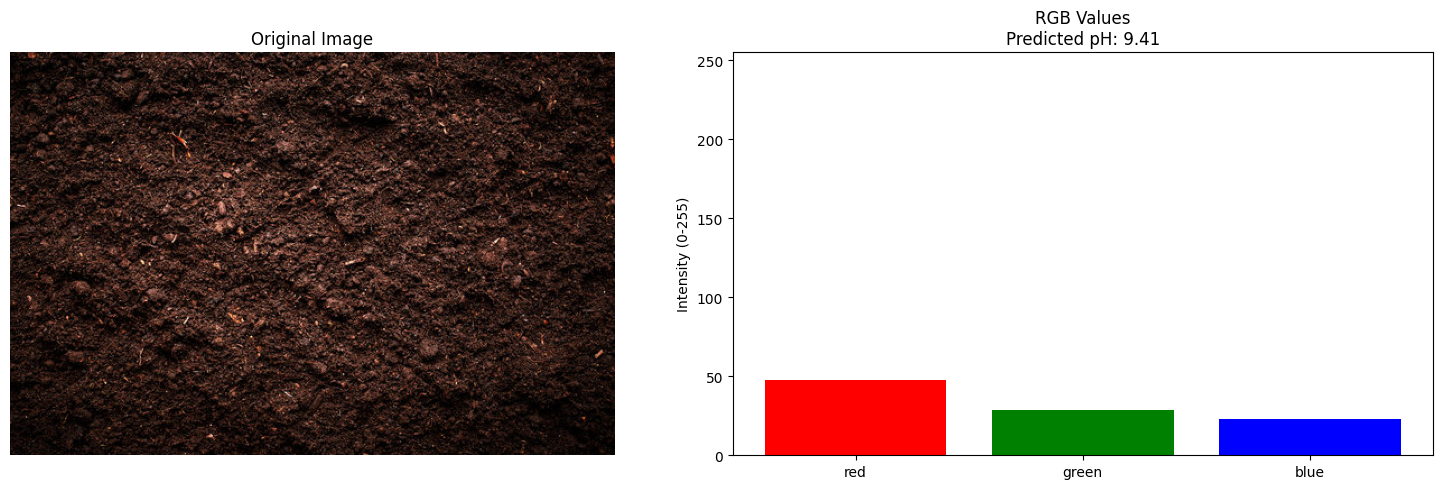


Results:
Extracted RGB Values: [47.36728909 28.33559156 22.92483025]
PCA Components: [-1.08851078 -0.04626921  0.45400992]
Predicted pH: 9.41


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanSquaredError  # Updated import
import joblib

def process_soil_image(image_path, roi_coords=None):
    """Process soil image and extract RGB values"""
    # Load image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Calculate average RGB values
    avg_rgb = np.mean(img, axis=(0,1))

    return img, avg_rgb # Return the full image, as no cropping is done


def predict_ph(image_path, model_path='soil_ph_model.h5',
               pca_path='pca_model.joblib',
               scaler_path='rgb_scaler.joblib'):
    """
    Main prediction function
    Returns: pH prediction, RGB values, PCA components, and original image
    """
    # Load pre-trained models with updated custom objects
    model = load_model(model_path, custom_objects={'mse': MeanSquaredError()})
    pca = joblib.load(pca_path)
    scaler = joblib.load(scaler_path)

    # Process image
    original_img, rgb_values = process_soil_image(image_path)

    # Preprocess RGB values
    rgb_normalized = scaler.transform([rgb_values])

    # Apply PCA
    pca_components = pca.transform(rgb_normalized)

    # Predict pH
    ph_pred = model.predict(pca_components)[0][0]

    return ph_pred, rgb_values, pca_components, original_img # Return original image


# Rest of the code remains the same as previous version
def display_results(original_img, rgb_values, ph_pred): # Removed cropped_img argument
    """Visualize results"""
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 2, 1) # Changed subplot to 1, 2, 1 since no cropped image is displayed
    plt.imshow(original_img)
    plt.title('Original Image')
    plt.axis('off')

    # RGB values
    plt.subplot(1, 2, 2) # Changed subplot to 1, 2, 2
    colors = ['red', 'green', 'blue']
    plt.bar(colors, rgb_values, color=colors)
    plt.title(f'RGB Values\nPredicted pH: {ph_pred:.2f}')
    plt.ylabel('Intensity (0-255)')
    plt.ylim(0, 255)

    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Load sample image
    image_path = "/content/soil image1.jpg"
    # Get prediction
    ph_value, rgb, pca_components, original_image = predict_ph(image_path) # Changed variable name

    # Display results
    display_results(original_image, rgb, ph_value) # Updated display_results call

    print("\nResults:")
    print(f"Extracted RGB Values: {rgb}")
    print(f"PCA Components: {pca_components[0]}")
    print(f"Predicted pH: {ph_value:.2f}")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import joblib  # For saving the model

# Load dataset
file_path = "/content/cleaned_fertilizer_data.xlsx"  # Update with your file path
df = pd.read_excel(file_path)

# Clean column names (remove spaces, newlines)
df.columns = df.columns.str.strip().str.replace(r'\s+', '_', regex=True)

# Verify column names
print("Columns in dataset:", df.columns)

# Ensure 'Crop_Type' exists after cleaning
if "Crop_Type" not in df.columns:
    raise KeyError("Column 'Crop_Type' not found. Check column names:", df.columns)

# Encode Crop Type (Convert categorical to numerical)
label_encoder = LabelEncoder()
df["Crop_Type"] = label_encoder.fit_transform(df["Crop_Type"])

X = df[["Crop_Type", "Kg/N/ac", "Kg/P/ac", "Kg/K/ac"]]
y = df[["N_Recommendation", "Urea", "Ammo_sulphate", "P2O5", "SSP", "DAP", "K2O", "MOP"]]

# Handle missing values (fill with median)
X = X.fillna(X.median())
y = y.fillna(y.median())

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save the trained model
joblib.dump(model, "fertilizer_model.pkl")
joblib.dump(label_encoder, "crop_encoder.pkl")

print("Model training complete and saved! 🎉")

Columns in dataset: Index(['Crop_Type', 'Kg/N/ac', 'N_Recommendation', 'Urea', 'Ammo_sulphate',
       'Kg/P/ac', 'P2O5', 'SSP', 'DAP', 'Kg/K/ac', 'K2O', 'MOP',
       'N_recommendation', 'Kg/K/a_c', 'Ammo_Sulphate', 'value_Kg/P/ac'],
      dtype='object')
Model training complete and saved! 🎉


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import joblib  # For saving and loading the model

# Load dataset
file_path = "/content/cleaned_fertilizer_data.xlsx"  # Update with your file path
df = pd.read_excel(file_path)

# Clean column names (remove spaces, newlines)
df.columns = df.columns.str.strip().str.replace(r'\s+', '_', regex=True)

# Verify column names
print("Columns in dataset:", df.columns)

# Ensure 'Crop_Type' exists after cleaning
if "Crop_Type" not in df.columns:
    raise KeyError("Column 'Crop_Type' not found. Check column names:", df.columns)

# Encode Crop Type (Convert categorical to numerical) - Fit on the entire column
label_encoder = LabelEncoder()
df["Crop_Type_Encoded"] = label_encoder.fit_transform(df["Crop_Type"]) # Create a new column for encoded values

# Define features (inputs) and target (outputs)
X = df[["Crop_Type_Encoded", "Kg/N/ac", "Kg/P/ac", "Kg/K/ac"]] # Use the encoded column
y = df[["N_Recommendation", "Urea", "Ammo_sulphate", "P2O5", "SSP", "DAP", "K2O", "MOP"]]

# Handle missing values (fill with median)
X = X.fillna(X.median())
y = y.fillna(y.median())

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save the trained model and label encoder
joblib.dump(model, "fertilizer_model.pkl")
joblib.dump(label_encoder, "crop_encoder.pkl")

print("Model training complete and saved! 🎉")

# ----------------------- PREDICTION FUNCTION -----------------------

def predict_fertilizer(crop_type, n, p, k):
    # Load the trained model and label encoder
    model = joblib.load("fertilizer_model.pkl")
    label_encoder = joblib.load("crop_encoder.pkl")

    # Encode the crop type
    try:
        crop_encoded = label_encoder.transform([crop_type])[0]
    except ValueError:
        print(f"Error: Crop type '{crop_type}' is not recognized by the model.")
        print("Please choose from the following supported crop types:", label_encoder.classes_)
        return # Exit the function if crop type is not recognized


    # Create input data
    input_data = np.array([[crop_encoded, n, p, k]])

    # Predict fertilizer values
    predicted_values = model.predict(input_data)[0]

    # Define output labels
    output_labels = ["N_Recommendation", "Urea", "Ammo_sulphate", "P2O5", "SSP", "DAP", "K2O", "MOP"]

    # Print the fertilizer recommendations
    print("\n🌾 **Fertilizer Recommendations for Crop:", crop_type, "**")
    for label, value in zip(output_labels, predicted_values):
        print(f"{label}: {value:.2f} kg/acre")

# ----------------------- USER INPUT -----------------------

# Get user input
crop_type_input = input("Enter Crop Type: ")

# Clean and convert numerical inputs to float
n_input = float(input("Enter Nitrogen (N) value: ").strip().split()[0])
p_input = float(input("Enter Phosphorus (P) value: ").strip().split()[0])
k_input = float(input("Enter Potassium (K) value: ").strip().split()[0])

# Predict and display fertilizer recommendations
predict_fertilizer(crop_type_input, n_input, p_input, k_input)

Columns in dataset: Index(['Crop_Type', 'Kg/N/ac', 'N_Recommendation', 'Urea', 'Ammo_sulphate',
       'Kg/P/ac', 'P2O5', 'SSP', 'DAP', 'Kg/K/ac', 'K2O', 'MOP',
       'N_recommendation', 'Kg/K/a_c', 'Ammo_Sulphate', 'value_Kg/P/ac'],
      dtype='object')
Model training complete and saved! 🎉
Enter Crop Type: Banana naipoovan
Enter Nitrogen (N) value: 163.70
Enter Phosphorus (P) value: 34.56
Enter Potassium (K) value: 167.98

🌾 **Fertilizer Recommendations for Crop: Banana naipoovan **
N_Recommendation: 102.00 kg/acre
Urea: 221.00 kg/acre
Ammo_sulphate: 388.00 kg/acre
P2O5: 22.00 kg/acre
SSP: 138.00 kg/acre
DAP: 48.00 kg/acre
K2O: 289.64 kg/acre
MOP: 484.00 kg/acre


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Load the dataset
file_path = "npkk.xlsx"  # Change this if needed
data = pd.read_excel(file_path)

# Set headers and clean data
data.columns = data.iloc[0]  # First row as header
data = data[1:]  # Drop header row
data = data[['pH', 'N', 'P', 'K']].apply(pd.to_numeric, errors='coerce').dropna()

# Prepare input and outputs
X = data[['pH']]
y_N = data['N']
y_P = data['P']
y_K = data['K']

# Fit normal linear regression models
model_N = LinearRegression().fit(X, y_N)
model_P = LinearRegression().fit(X, y_P)
model_K = LinearRegression().fit(X, y_K)

# Function to print linear equation
def print_linear_eq(model, label):
    coef = model.coef_[0]
    intercept = model.intercept_
    print(f"{label} = {coef:.2f} * pH + {intercept:.2f}")

# Print equations
print("Linear Regression Equations:\n")
print_linear_eq(model_N, "Nitrogen (N)")
print_linear_eq(model_P, "Phosphorus (P)")
print_linear_eq(model_K, "Potassium (K)")

Linear Regression Equations:

Nitrogen (N) = -7.43 * pH + 229.28
Phosphorus (P) = 7.63 * pH + -25.51
Potassium (K) = -32.41 * pH + 422.80
